In [1]:
import cv2
import os
import torch
import random
import numpy as np
from albumentations.pytorch import ToTensorV2
import albumentations as A
from PIL import Image, ImageDraw, ImageFont
from torch.utils.data import Dataset
import json
import cv2
from collections import defaultdict

In [2]:


def get_json_data(root_dir,train=True):
    """_summary_
    json 파일에서 데이터를 읽어오는 함수

    Args:
        root_dir (str): json 파일이 들어 있는 폴더

    Returns:
        json_data (dict): json data가 들어 있는 dictionary
    """
    if train:
        file_name = 'train.json'
    else:
        file_name = 'test.json'

    json_path = os.path.join(root_dir, file_name)

    with open(json_path) as f:
        json_data = json.load(f)
    
    return json_data

def get_all_annotation(json_data):
    """_summary_
    json_data에서 annotation 정보들을 dict(list)로 추출

    Args:
        json_data (dict): json_data

    Returns:
        annotation (dict): key = img id, value = annotation 정보가 들어있는 list
    """
    anno = defaultdict(list)
    for i in json_data['annotations']:
        anno[str(i['image_id'])].append(i)
    
    return anno


def split_train_valid(root_dir, json_data, val_ratio=0.2):
    """_summary_

    Args:
        root_dir (str): data가 들어있는 폴더 path
        json_data (dict): json data가 들어잇는 data
        val_ratio (float, optional): train, valid set을 나누는 비율. Defaults to 0.2.

    Returns:
        train, val path_info (list): [id, image_paths]의 데이터를 train과 validation info를 return
    """
    
    image_info = np.array([[i['id'], os.path.join(root_dir,i['file_name']) ] for i in json_data['images']])
    # validation set legnth
    length = int(len(image_info))
    split_length = int(val_ratio * length)

    # shuffle
    idx = np.random.permutation(image_info.shape[0])
    image_info = image_info[idx]
    
    # split info
    train_info = image_info[:length-split_length]
    val_info = image_info[length-split_length:]
    return train_info, val_info


class CustomDataset(Dataset):
    classes = ['background',
               'General trash', 
               'Paper', 
               'Paper pack', 
               'Metal', 
               'Glass', 
               'Plastic', 
               'Styrofoam', 
               'Plastic bag', 
               'Battery', 
               'Clothing']
    
    classes_id = [i for i in range(len(classes))]

    def __init__(self, image_info, json_anno, transforms=None, mosaic = False):
        self._transforms = transforms
        
        self.num_classes = len(self.classes)
        self.image_ids = image_info[:,0]
        self.image_paths = image_info[:,1]
        self.all_annotation = json_anno
        self.width = 1024
        self.height = 1024
        self.masaic = mosaic

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,idx):
        iscrowds = []
        image_ids = []
        boxes = []
        labels = []
        areas = []

        if self.masaic:
            img, labels, boxes, areas, image_ids, iscrowds = self._mosaic(idx)
        else:
            img_path = self.image_paths[idx]
            # print(img_path)
            img = self._load_img(img_path)

            image_id = self.image_ids[idx]

            # albumentation 을 사용하기위해 box.xyxy 로 변경하기
            objs=[]
            for obj in self.all_annotation[image_id]:
                new_box = self._xywh2xyxy(obj['bbox'])
                if len(new_box):
                    obj['clean_bbox'] = new_box
                    objs.append(obj)

            image_id = int(image_id)
            for ix, obj in enumerate(objs):
                boxes.append(obj['clean_bbox'])
                labels.append(obj['category_id']+1) 
                iscrowds.append(int(obj['iscrowd']))
                image_ids.append(image_id)
                areas.append(obj['area'])

        if self._transforms:
            # albumentation 후 coco는 box.xywh로 나오게 된다, pascal은 box.xyxy
            output = self._transforms(image=img,bboxes=boxes, labels=labels)
            img = output['image']
            boxes = output['bboxes']
            labels = output['labels']

            iscrowds = torch.as_tensor(iscrowds, dtype=torch.int32)
            image_id = torch.as_tensor(image_ids, dtype=torch.int32)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int32)
            areas = torch.as_tensor(areas, dtype= torch.float32)

        target = {"boxes": boxes, "labels": labels, "image_id": image_id, "area": areas, "iscrowd": iscrowds}
        # if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
        #     img, target = self.__getitem__(idx+1)
        return img, target

    def _load_img(self,path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        return img

    def _xywh2xyxy(self,box):
        x1 = np.max((0, box[0]))
        y1 = np.max((0, box[1]))
        x2 = np.min((self.width - 1, x1 + np.max((0, box[2] - 1))))
        y2 = np.min((self.height - 1, y1 + np.max((0, box[3] - 1))))
        if x2 > x1 and y2 > y1:
            return [x1,y1,x2,y2]
        else:
            return []

    def _check_box(self,objs,box,shift_x,shift_y,boxes,labels, areas, image_ids, iscrowds):
        for obj in objs:
            new_box = self._xywh2xyxy(obj['bbox'])
            if len(new_box):
                x1 = max(new_box[0],box[0]) + shift_x
                y1 = max(new_box[1],box[1]) + shift_y
                x2 = min(new_box[2],box[2]) + shift_x
                y2 = min(new_box[3],box[3]) + shift_y
                if x2 > x1 and y2 > y1:
                    boxes.append([x1,y1,x2,y2])
                    labels.append(obj['category_id']+1)
                    areas.append((x2-x1)*(y2-y1))
                    image_ids.append(int(obj['image_id']))
                    iscrowds.append(int(obj['iscrowd']))


    def _mosaic(self,idx) :
        labels4 = []
        boxes4 = []
        image_ids4 = []
        areas4 = []
        iscrowds4 = []
        mosaic_border = [random.uniform(0.2, 0.8), random.uniform(0.2, 0.8)]
        # center point
        yc, xc = (int(1024*x) for x in mosaic_border)  # mosaic center x, y # 81 172
        # random index, 4 images
        n = len(self.image_paths)
        indices_ = range(n)
        indices = random.choices(indices_, k=3)  # 3 additional image indices # [0, 3292, 20762, 18713]
        indices.append(idx)
        random.shuffle(indices)  # [18713, 0, 20762, 3292]

        img4 = np.zeros((self.width , self.height , 3), dtype=np.float32)  # base image with 4 tiles
        for i, index in enumerate(indices):
            # Load image
            img = self._load_img(self.image_paths[index])
            ann = self.all_annotation[self.image_ids[index]]
            min_x, min_y, max_x, max_y = 0,0,1024,1024
            c_min_x, c_min_y, c_max_x, c_max_y = 0,0,1024,1024
            shift_x, shift_y = 0,0
            # place img in img4
            if i == 0:  # top left 0,0,1024-xc,1024-yc , xc,yc,1024,1024
                max_x,max_y = 1024-xc, 1024-yc
                c_min_x,c_min_y = xc,yc
                shift_x, shift_y = -xc,-yc

            elif i == 1:  # top right 1024-xc,0,1024,1024-yc , 0,yc,xc,1024
                min_x,max_y = 1024-xc, 1024-yc
                c_max_x,c_min_y = xc,yc
                shift_x, shift_y = 1024-xc,-yc

            elif i == 2:  # bottom left 0,1024-yc,1024-xc,1024, xc,0,1024,yc
                max_x,min_y = 1024-xc, 1024-yc
                c_min_x,c_max_y = xc,yc
                shift_x, shift_y = -xc,1024-yc

            elif i == 3:  # bottom right 1024-xc,1024-yc,1024,1024, 0,0,xc,yc
                min_x,min_y = 1024-xc, 1024-yc
                c_max_x,c_max_y = xc,yc
                shift_x, shift_y = 1024-xc,1024-yc

            # concat image
            img4[min_y: max_y, min_x:max_x] = img[c_min_y: c_max_y, c_min_x:c_max_x]  # img4[ymin:ymax, xmin:xmax]


            self._check_box(ann, 
                            [c_min_x, c_min_y, c_max_x, c_max_y],
                            shift_x,shift_y,
                            boxes4, labels4, areas4, image_ids4, iscrowds4)

        return img4, labels4, boxes4, areas4, image_ids4, iscrowds4
    
    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))




In [3]:
data_root_dir = '/opt/ml/dataset'
json_data = get_json_data(data_root_dir)
    
json_anno = get_all_annotation(json_data)

train_info, val_info = split_train_valid(data_root_dir, json_data)

print(train_info[3])
print(json_anno[train_info[3][0]])
data_transform = {
        "train": A.Compose([
            # A.HorizontalFlip(p=1),
            # A.RandomBrightnessContrast(p=0.5),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels'])),
        "val": A.Compose([
            ToTensorV2(),
            ], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels']))
    }


dataset = CustomDataset(train_info, json_anno,data_transform['train'],mosaic=True)

['1878' '/opt/ml/dataset/train/1878.jpg']
[{'image_id': 1878, 'category_id': 1, 'area': 378212.6, 'bbox': [171.4, 121.6, 588.2, 643.0], 'iscrowd': 0, 'id': 8943}]


In [4]:
img,d = dataset.__getitem__(2)
d

{'boxes': tensor([[   0.0000,  206.7000,  330.6000,  385.5000],
         [ 467.9000,    0.0000, 1024.0000,  631.4000],
         [   0.0000,  918.0000,  129.9000, 1024.0000],
         [ 432.6000,  889.3000, 1024.0000, 1024.0000],
         [ 332.0000,  693.0000,  588.0000, 1024.0000]]),
 'labels': tensor([8, 2, 6, 8, 1], dtype=torch.int32),
 'image_id': tensor([ 904, 4757,   93, 1414, 1414], dtype=torch.int32),
 'area': tensor([ 59111.2812, 351121.5312,  13769.4004,  79661.5781,  84736.0000]),
 'iscrowd': tensor([0, 0, 0, 0, 0], dtype=torch.int32)}

img shape torch.Size([3, 1024, 1024])
['background', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


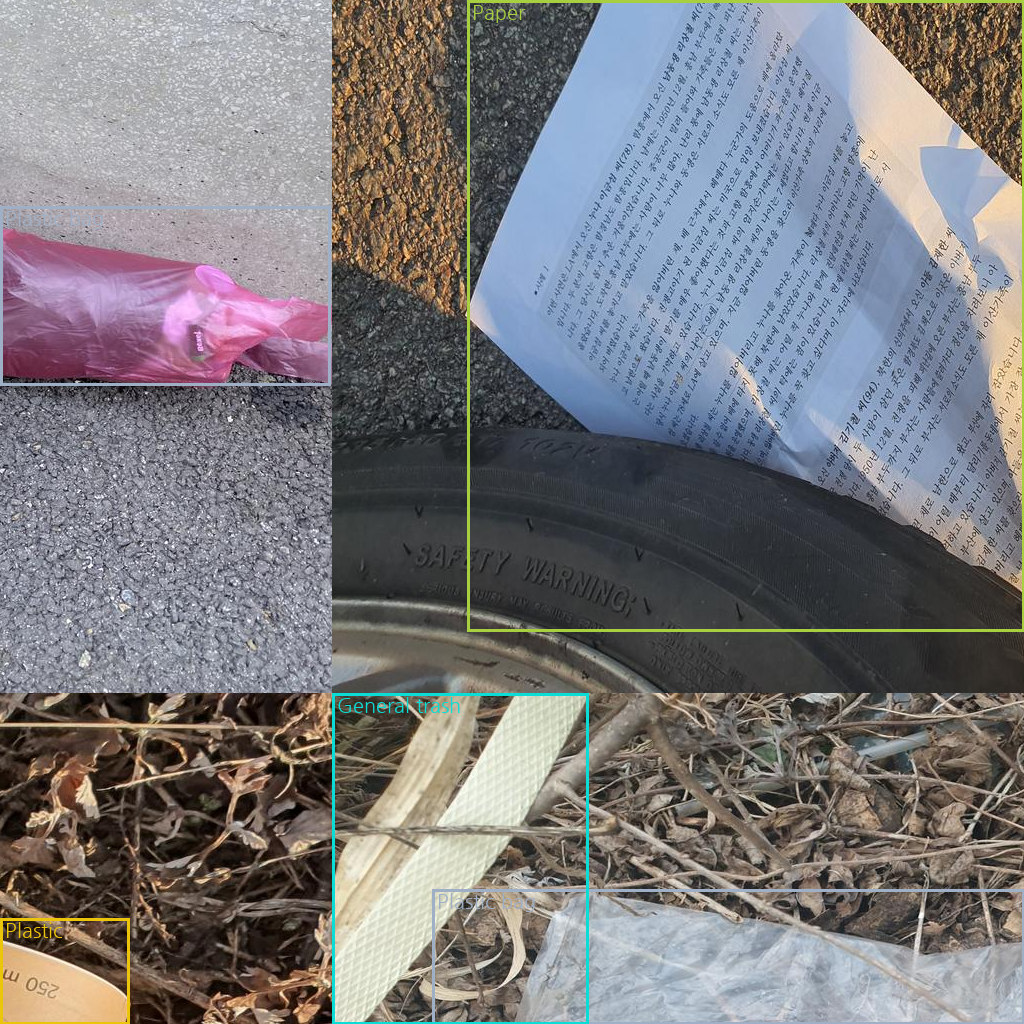

In [5]:
import random
print(f"img shape {img.shape}")
img = (img*255).permute(1,2,0).numpy().astype(np.uint8)
img = Image.fromarray(img)
boxes = d['boxes'].numpy()
labels = d['labels'].numpy()
classes = dataset.classes
print(classes)
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(len(classes))]
draw = ImageDraw.Draw(img)
for i in range(len(boxes)):
    box = boxes[i]
    label = labels[i]
    color = colors[label]
    font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothic.ttf',20)
    draw.rectangle(box, outline=color, width=3)
    draw.text((box[0]+5,box[1]),  classes[label], font=font, fill=color)
img.show()